In [ ]:
import os
from google.colab import files

# Prompt the user to upload the kaggle.json file
print("Please upload your kaggle.json file")
uploaded = files.upload()

# Check if the file was uploaded
if 'kaggle.json' in uploaded:
    print("kaggle.json uploaded successfully!")

    # Create the .kaggle directory and configure the API token
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API token configured.")

    # Download and unzip the dataset
    print("\nDownloading dataset from Kaggle...")
    !kaggle datasets download -d hasyimabdillah/workoutexercises-images
    print("Unzipping dataset...")
    !unzip -o -q workoutexercises-images.zip -d dataset
    print("Dataset ready.")

    # Install all required libraries
    print("\nInstalling dependencies...")
    !pip install torch torchvision timm scikit-learn pandas seaborn matplotlib imutils tqdm --upgrade -q
    print("Dependencies installed.")

else:
    print("Upload failed. Please re-run the cell and upload kaggle.json.")

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import shutil
from imutils import paths
import time
import copy
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import timm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset paths
data_dir = Path("dataset")
train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"

def prepare_dataset():
    if not train_dir.exists():
        print("Creating train/val/test splits...")
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        image_paths = list(paths.list_images(data_dir))
        train_paths, rest_paths = train_test_split(image_paths, test_size=0.3, stratify=[Path(p).parent.name for p in image_paths], random_state=42)
        val_paths, test_paths = train_test_split(rest_paths, test_size=0.5, stratify=[Path(p).parent.name for p in rest_paths], random_state=42)

        print("Copying images...")
        for path_list, folder in zip([train_paths, val_paths, test_paths], [train_dir, val_dir, test_dir]):
            for img_path in tqdm(path_list, desc=f"Copying to {folder.name}"):
                label = Path(img_path).parent.name
                label_dir = folder / label
                label_dir.mkdir(parents=True, exist_ok=True)
                shutil.copy(img_path, label_dir / Path(img_path).name)
    else:
        print("Train/val/test directories already exist.")

def get_transforms():
    return {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            # Convert to Tensor BEFORE RandomErasing and Normalize
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            # RandomErasing must be applied on a Tensor
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)),
        ]),
        "val": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

def get_dataloaders(batch_size=32):
    transforms_dict = get_transforms()
    datasets_dict = {
        "train": datasets.ImageFolder(train_dir, transform=transforms_dict["train"]),
        "val": datasets.ImageFolder(val_dir, transform=transforms_dict["val"]),
        "test": datasets.ImageFolder(test_dir, transform=transforms_dict["val"])
    }
    dataloaders = {
        'train': DataLoader(datasets_dict['train'], batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
        'val': DataLoader(datasets_dict['val'], batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
        'test': DataLoader(datasets_dict['test'], batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    }
    return dataloaders, datasets_dict['train'].classes

# Run the preparation functions
prepare_dataset()
dataloaders, class_names = get_dataloaders()
print(f"Dataloaders created. Found {len(class_names)} classes.")

In [4]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30, patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    os.makedirs('models', exist_ok=True)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{torch.sum(preds == labels.data).item() / inputs.size(0):.4f}'})

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, 'models/best_model.pth')
                    print(f'New best model saved! Val Acc: {best_acc:.4f}')
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs.')
            break

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

def test_model(model, dataloader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\n--- Test Set Evaluation ---")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(18, 15))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=20)
    plt.ylabel('Actual Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)

    cm_path = 'models/confusion_matrix.png'
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to {cm_path}")
    plt.show()

Initializing model...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Starting training...

Epoch 1/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 1.6178 Acc: 0.5450


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.2871 Acc: 0.9254
New best model saved! Val Acc: 0.9254

Epoch 2/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.5019 Acc: 0.8606


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0923 Acc: 0.9774
New best model saved! Val Acc: 0.9774

Epoch 3/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.2963 Acc: 0.9155


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0528 Acc: 0.9856
New best model saved! Val Acc: 0.9856

Epoch 4/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.2010 Acc: 0.9413


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0356 Acc: 0.9904
New best model saved! Val Acc: 0.9904

Epoch 5/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.1558 Acc: 0.9532


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0285 Acc: 0.9942
New best model saved! Val Acc: 0.9942

Epoch 6/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.1377 Acc: 0.9629


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0267 Acc: 0.9933

Epoch 7/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.1173 Acc: 0.9630


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0232 Acc: 0.9942

Epoch 8/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.0980 Acc: 0.9698


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0247 Acc: 0.9913

Epoch 9/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.0941 Acc: 0.9726


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0222 Acc: 0.9937

Epoch 10/30
----------


Train Phase:   0%|          | 0/304 [00:00<?, ?it/s]

Train Loss: 0.0917 Acc: 0.9732


Val Phase:   0%|          | 0/65 [00:00<?, ?it/s]

Val Loss: 0.0213 Acc: 0.9942

Early stopping triggered after 10 epochs.

Training complete in 20m 28s
Best val Acc: 0.9942

--- Training Complete ---
Final model saved to models/final_model.pth

Loading best model for final evaluation on the test set...


Testing:   0%|          | 0/65 [00:00<?, ?it/s]


--- Test Set Evaluation ---
                     precision    recall  f1-score   support

barbell biceps curl     0.9725    1.0000    0.9860       106
        bench press     0.9681    0.9785    0.9733        93
  chest fly machine     1.0000    1.0000    1.0000        79
           deadlift     0.9875    1.0000    0.9937        79
decline bench press     0.9615    0.9740    0.9677        77
        hammer curl     0.9877    0.9756    0.9816        82
         hip thrust     0.9767    1.0000    0.9882        84
incline bench press     0.9818    0.9818    0.9818       110
       lat pulldown     0.9898    1.0000    0.9949        97
     lateral raises     0.9921    0.9843    0.9881       127
      leg extension     0.9775    0.9886    0.9831        88
         leg raises     1.0000    1.0000    1.0000        77
              plank     1.0000    0.9933    0.9966       149
            pull up     0.9890    0.9783    0.9836        92
            push up     0.9890    1.0000    0.9945     

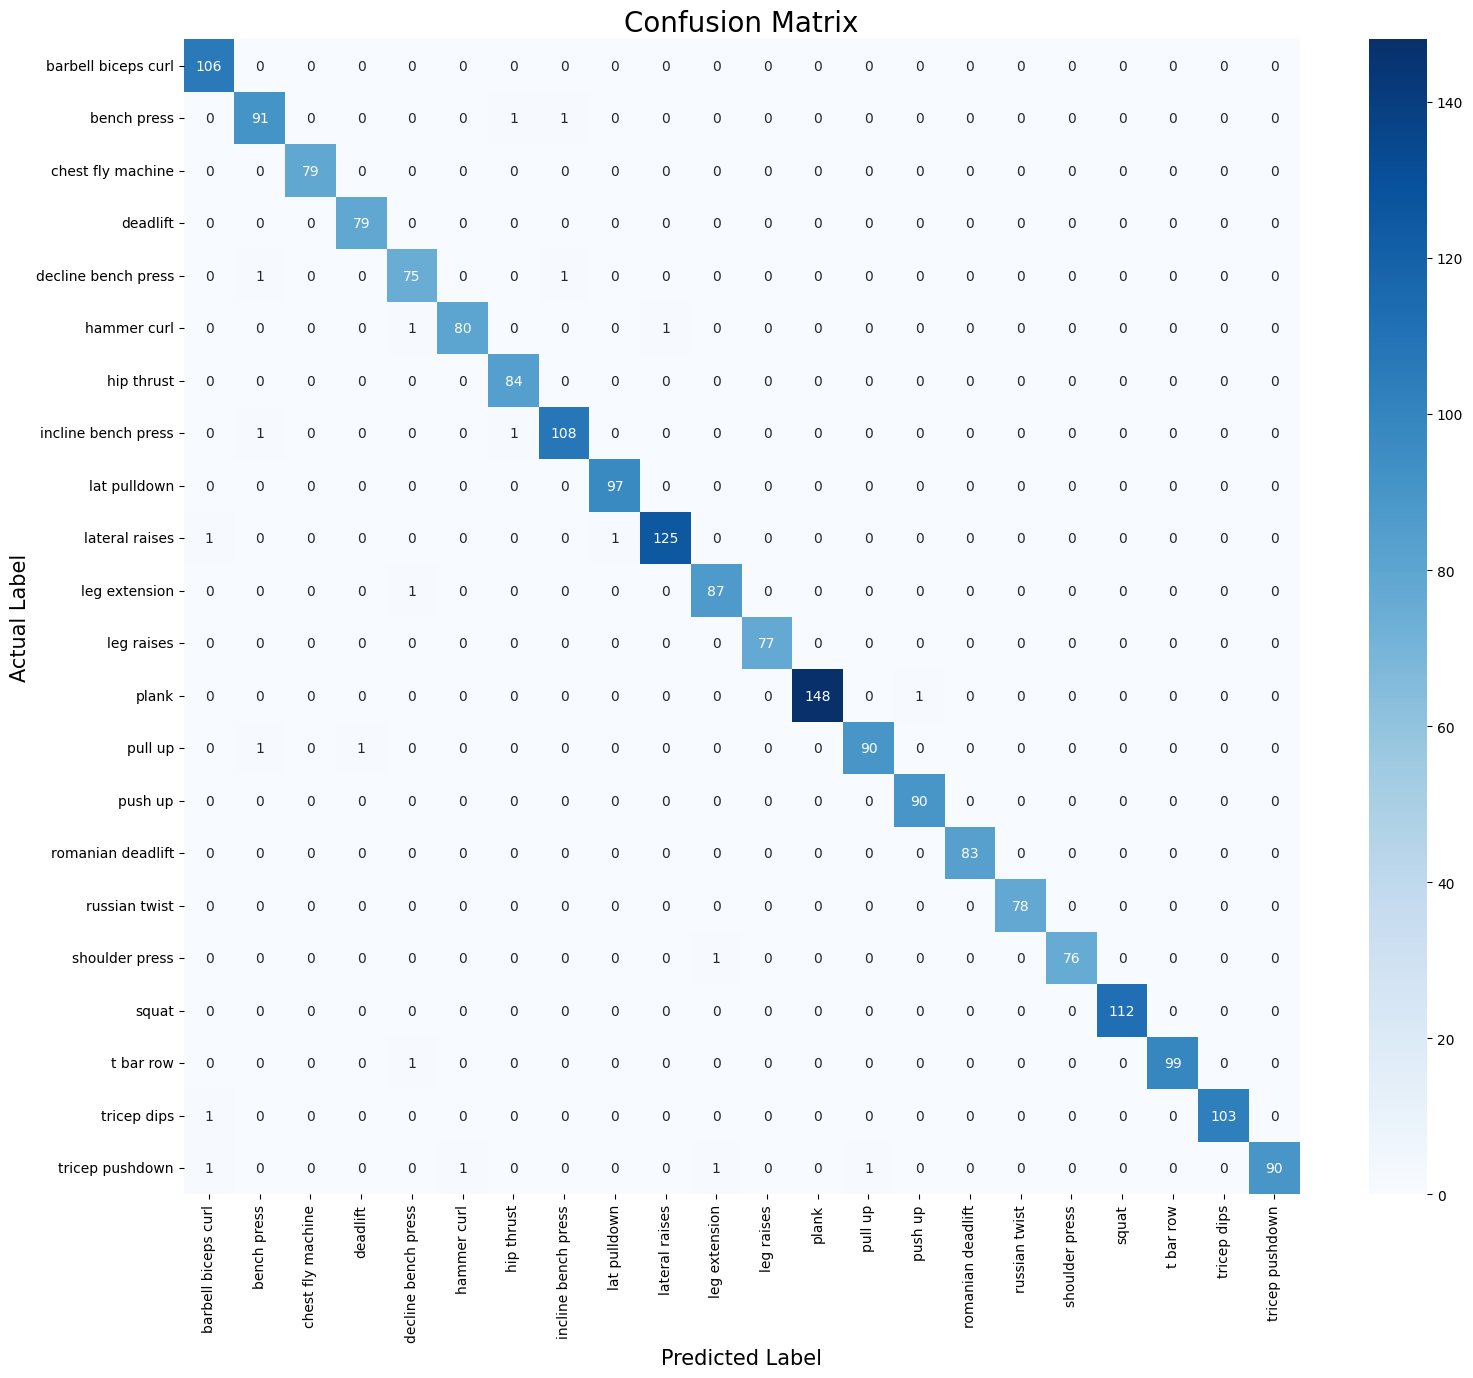

In [5]:
print("Initializing model...")
num_classes = len(class_names)

# Use a powerful pre-trained model from the 'timm' library
model = timm.create_model('efficientnet_b3a', pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# The 'verbose' argument has been removed from this line to fix the error
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

print("Starting training...")
trained_model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=30, patience=5)

print("\n--- Training Complete ---")
torch.save(trained_model.state_dict(), 'models/final_model.pth')
print("Final model saved to models/final_model.pth")

print("\nLoading best model for final evaluation on the test set...")
trained_model.load_state_dict(torch.load('models/best_model.pth'))
test_model(trained_model, dataloaders['test'], class_names)
